In [1]:
import numpy as np
import numba
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys
import os

from eigenwell.src import grid, pml, pec_pmc
from eigenwell.src.constants import *

from scipy.sparse.linalg import splu

#import eigenwell.boundary
print(os.listdir())


['.DS_Store', '2d photonic crystal.ipynb', 'eigensolving with SLEPc.ipynb', 'dielectric waveguide analytic comparison.ipynb', 'check_pml.ipynb', 'test_grid_preconditioners.ipynb', 'complex_waveguides_with_impedance_transformations.ipynb', '3D perfect metal waveguide solve.ipynb', 'mode_filtering.ipynb', 'K-eigensolver 1D Bragg Mirror-1D Photonic Crystal.ipynb', 'test_bloch_boundary.ipynb', 'TE vs TM.ipynb', 'non uniform grid.ipynb', '.ipynb_checkpoints', 'array ordering of numpy.ipynb', 'dielectric waveguide.ipynb', 'IMI-MIM k-eigensolver.ipynb']


## Equations for a general waveguide with propagation constant $\beta$ in z
\begin{equation}
    \omega^2 \mu_0 T_{\epsilon_y}h_x - T_{\epsilon_y} D_y^{f}T_{\epsilon_z}^{-1}\bigg(D_x^{b}h_y - D_y^{b}h_x\bigg) + D_x^{b}\bigg(D_x^{f}h_x - D_y^{f}h_y \bigg) = \beta^2 h_x
\end{equation}
\begin{equation}
    \omega^2 \mu_0 T_{\epsilon_y}h_x - T_{\epsilon_y} D_y^{f}T_{\epsilon_z}^{-1}\bigg(D_x^{b}h_y - D_y^{b}h_x\bigg) + D_x^{b}\bigg(D_x^{f}h_x - D_y^{f}h_y \bigg) = \beta^2 h_x
\end{equation}

In full operator notation
\begin{equation}
    \omega^2 \mu_0 \begin{bmatrix}
        T_{\epsilon_y} & \\
        & T_{\epsilon_x} 
    \end{bmatrix}
    +
    \begin{bmatrix}
        T_{\epsilon_y} & \\
        & T_{\epsilon_x} 
    \end{bmatrix}     \begin{bmatrix}
        -D_y^{f} \\
        D_x^{f}
    \end{bmatrix} T_{\epsilon_z}^{-1} \begin{bmatrix}
        -D_y^{b} &
        D_x^{b}
    \end{bmatrix} +\begin{bmatrix}
        D_x^{b} \\
        D_y^{b}
    \end{bmatrix} \begin{bmatrix}
        D_x^{f} &
        D_y^{f}
    \end{bmatrix}
\end{equation}



In [2]:
def grid_average(center_array, w):
    '''
        center_array, 1d eps_r
    '''
    # computes values at cell edges

    xy = {'x': 0, 'y': 1}
    center_shifted = np.roll(center_array, 1, axis=xy[w])
    avg_array = (center_shifted+center_array)/2
    return avg_array

[-5e-07, 5e-07]


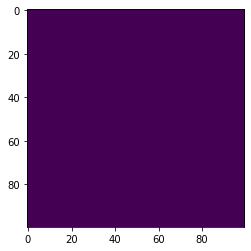

(20000, 10000)
(20000, 20000) <class 'scipy.sparse.csr.csr_matrix'>
2.511562061214068 1.2566370614359173e-06 96048


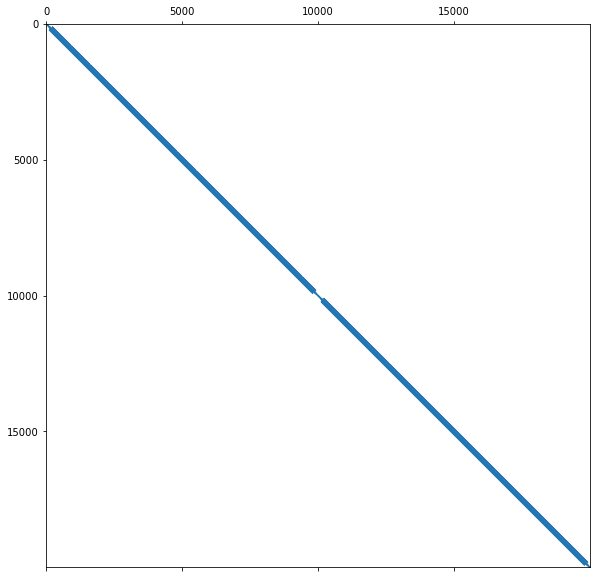

In [3]:
L0 = 1e-6

N = [100,100]
Npml = [5,5]
dL = [0.01*L0, 0.01*L0]
Lx, Ly = [N[0]*dL[0], N[1]*dL[1]]
xrange = [-Lx/2, Lx/2]
yrange = [-Ly/2, Ly/2]
print(xrange)

wvlen = 0.75e-6;

omega = 2*np.pi*C0/wvlen;

pml_obj =  pml.PML(N,Npml, omega);
pml_obj.Soperators(xrange, yrange);

pec_pmc_obj = pec_pmc.PEC_PMC(N);

epsilon = np.ones(N)
#epsilon[30:70, 30:70] = 5
plt.figure();
plt.imshow(epsilon);
plt.show();
M = np.prod(N)
epxx= grid_average(epsilon,'x')
epyy = grid_average(epsilon, 'y')

Tez = sp.diags(EPSILON0*epsilon.flatten(), 0, (M,M))
Tey = sp.diags(EPSILON0*epyy.flatten(), 0, (M,M))
Tex = sp.diags(EPSILON0*epxx.flatten(), 0,(M,M))
invTez = sp.diags(1/(EPSILON0*epsilon.flatten()), 0, (M,M))

fd = grid.FiniteDifferenceGrid(dL,N)
mx = pec_pmc_obj.mask_x;
my = pec_pmc_obj.mask_y;

#fd.make_derivatives(PML = None, PEC_PMC = pec_pmc)
Dxf = fd.Dxf
Dxb = fd.Dxb
Dyf = fd.Dyf
Dyb = fd.Dyb

Mx = sp.bmat([[mx, None],
              [None,mx]])
My = sp.bmat([[my, None],
              [None,my]])

## generate operator
Dop1 = sp.bmat([[-Dyf], [Dxf]])
print(Dop1.shape)

Dop2 = sp.bmat([[-Dyb,Dxb]])

Dop3 = sp.bmat([[Dxb], [Dyb]])
Dop4 = sp.bmat([[Dxf,Dyf]])


Tep = sp.block_diag((Tey, Tex))

#A = omega**2*MU0*Tep + Tep@(Dop1)@invTez@(Dop2) + Dop3@Dop4


A = omega**2*MU0*Tep + Mx@My@Tep@(Dop1)@invTez@(Dop2)@My@Mx + Mx@My@Dop3@Dop4@My@Mx

print(A.shape, type(A))
plt.figure(figsize = (10,10))
plt.spy(A, markersize = 0.1)
#plt.spy(Tep@(Dop1)@invTez@(Dop2), markersize = 0.1)

print(omega*1e-15, MU0, A.count_nonzero())

In [4]:
B = splu(A);
print(B.L.count_nonzero())

Apbc = omega**2*MU0*Tep + Tep@(Dop1)@invTez@(Dop2) + Dop3@Dop4
B = splu(Apbc);
print(B.L.count_nonzero())

/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


629222
1177752


In [5]:
# ## matrix operations
# plt.figure(figsize = (10,10))
# plt.spy((Dop1)@invTez@(Dop2), markersize = 0.1)
# plt.figure(figsize = (10,10))
# plt.spy((Dop3@Dop4), markersize = 0.1)



In [6]:
## use eigs
from scipy.sparse.linalg import eigs
K = 12
print(A.shape)

neff = np.sqrt(np.max(np.real(epsilon)));
beta_est = abs(2*np.pi*neff / (wvlen));
sigma = beta_est**2;

print(sigma)

# vals, vecs = eigs(A, k = K, sigma = sigma)
vals, vecs = eigs(A, k = K, which = 'SM')

(20000, 20000)
70183853518857.65


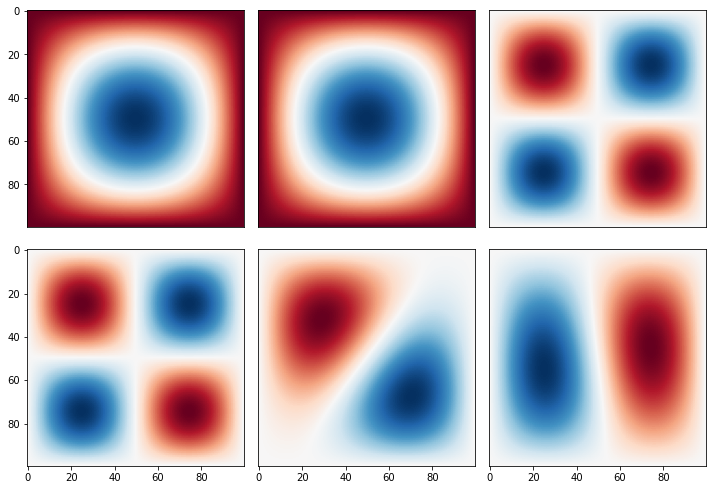

In [7]:
plt.figure(figsize = (10,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    v = vecs[:,i]
    hx = v[0:np.prod(N)].reshape(N)
    hy = v[np.prod(N):].reshape(N)
    plt.imshow(np.real(hy), cmap = 'RdBu')
    if(i<3):
        plt.xticks([])
    if(i!= 0 and i!=3):
        plt.yticks([])
plt.savefig('../img/conductor_3D_waveguide.png',dpi = 300)
plt.tight_layout();
plt.show();

In [8]:
## try to do a 3d plot of this waveguide

## Circular Metal Waveguide

[-5e-07, 5e-07]


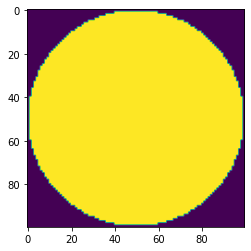

In [10]:
# ## use eigs
# from eigenwell.src.eigen_guide import *
# fd = grid.FiniteDifference(dL,N)

# eigen3D = EigenGuide3D(epsilon, fd)
print(xrange)

x = np.linspace(xrange[0],xrange[1], N[0])
y = np.linspace(yrange[0], yrange[1], N[1])

X,Y = np.meshgrid(x,y)

eps_r = np.ones(N);
mask = np.zeros(N);
mask[X**2+Y**2<(5e-7)**2] = 1;
plt.imshow(mask)

pec_pmc_obj.set_custom_mask(mask);

Mcircle = sp.bmat([[pec_pmc_obj.mask,None],[None,pec_pmc_obj.mask]]);

Acirc = omega**2*MU0*Tep + Mcircle@(Tep@(Dop1)@invTez@(Dop2)  + Dop3@Dop4)@Mcircle 


In [18]:
vals, vecs = eigs(Acirc, k = 12, which = 'SM')

<ipython-input-29-ed1047575620>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X/1e-6,Y/1e-6,np.real(hy), cmap = 'RdBu')


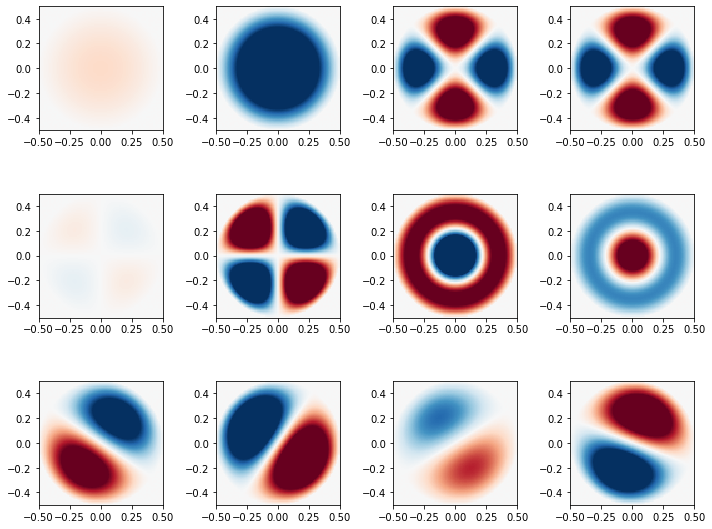

In [29]:
plt.figure(figsize = (10,8))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    v = vecs[:,i]
    hx = v[0:np.prod(N)].reshape(N)
    hy = v[np.prod(N):].reshape(N)
    plt.pcolormesh(X/1e-6,Y/1e-6,np.real(hy), cmap = 'RdBu')
    plt.clim(-0.01, 0.01)
    ax.set_aspect('equal')
plt.tight_layout();

plt.savefig('metal_cylindrical_waveguide.png',dpi = 300)

In [42]:
print(np.min(np.real(hx)))

-0.021741660768675137


6006547.325490632j
0j


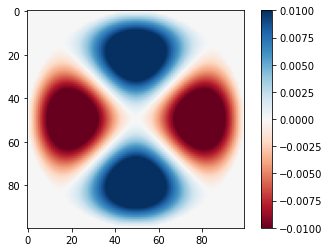

3.161340697626649j


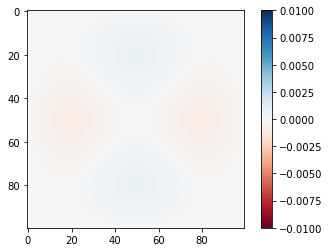

6.322681395253298j


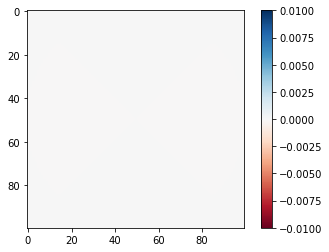

9.484022092879947j


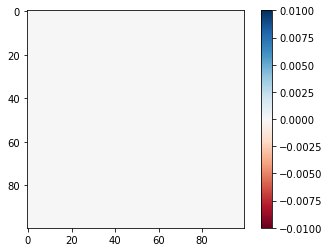

12.645362790506596j


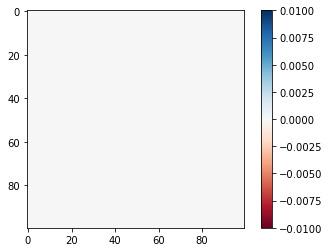

15.806703488133245j


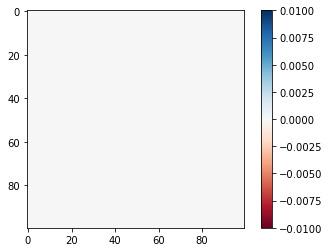

18.968044185759894j


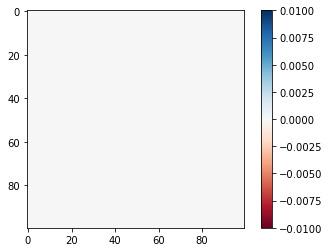

22.12938488338654j


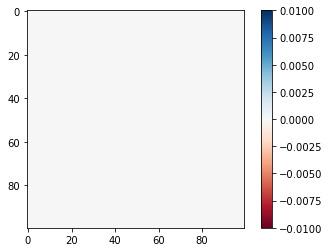

25.29072558101319j


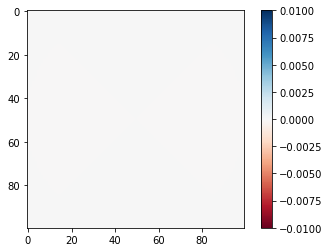

28.45206627863984j


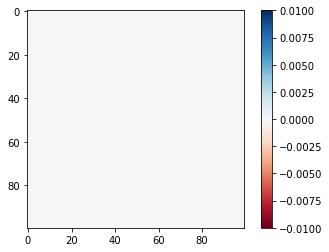

31.61340697626649j


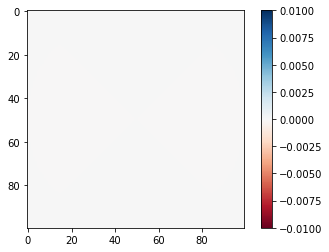

34.77474767389314j


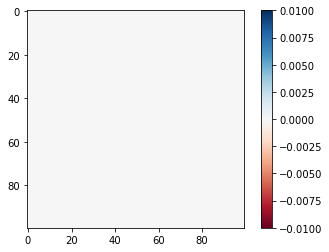

37.93608837151979j


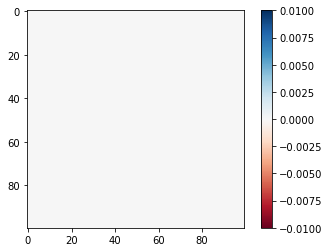

41.097429069146436j


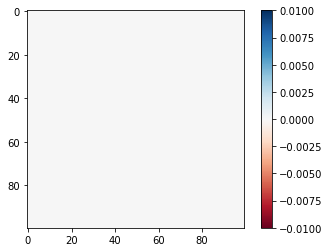

44.25876976677308j


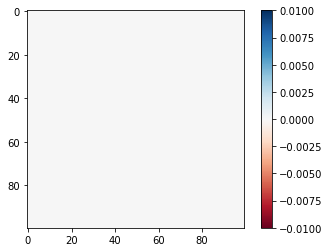

47.420110464399734j


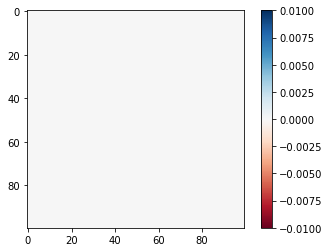

50.58145116202638j


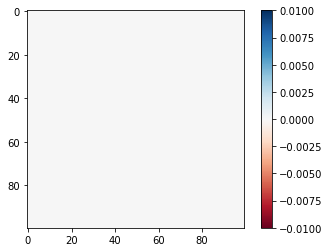

53.742791859653025j


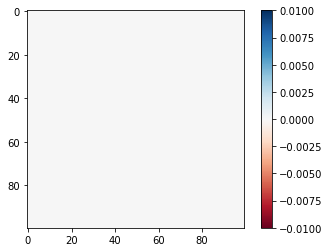

56.90413255727968j


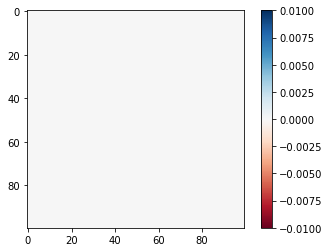

60.06547325490632j


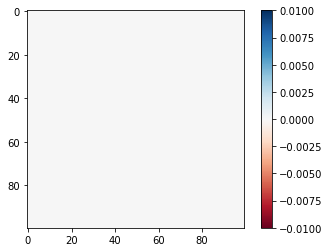

In [57]:
import plotly.graph_objects as go


## make a 3D image of this based on beta...
z_scan = np.linspace(0, 2e-6, 0)
X,Y,Z = np.meshgrid(x,y,z_scan)

i = 2

field_slices = [];
v = vecs[:,i]
beta_squared = vals[i]
beta = np.sqrt(beta_squared);
print(beta)
hx = v[0:np.prod(N)].reshape(N)
hy = v[np.prod(N):].reshape(N)
for z in z_scan:
    field_slices.append(hx*np.exp(1j*beta*z));
    print(beta*z)
    plt.imshow(np.real(field_slices[-1]), cmap = 'RdBu')
    plt.clim(-0.01, 0.01)
    plt.colorbar();
    plt.show()
field_slices = np.array(field_slices)

    
